# Telecom Churn Case Study

## 1. Importing Important Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 2. Importing and Reading the Dataset

In [2]:
churn_org_data = pd.read_csv("telecom_churn_data.csv")
churn_org_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


## 3. Checking the Data Quality

In [3]:
churn_org_data.shape

(99999, 226)

In [4]:
churn_org_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [5]:
# Creating a copy of data to work

churn_working_data = churn_org_data.copy()

In [6]:
all_columns = churn_org_data.columns.tolist()

We assume that there are three phases of customer lifecycle :

- The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

- The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

- The ‘churn’ phase: In this phase, the customer is said to have churned. We define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, we discard all data corresponding to this phase.

In this case, since we are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase

## 4. High Value Customer

High-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [7]:
recharge_col = [col for col in all_columns if 'rech' in col]
recharge_col

['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_num_9',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'total_rech_amt_9',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'max_rech_amt_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'total_rech_data_9',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'max_rech_data_9',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_2g_9',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'count_rech_3g_9',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'av_rech_amt_data_9']

#### 4.1 Let's understand the high value customer data w.r.t. Recharge Amount

We know the total amount of money spent on talktime recharges, but we don't have the exact amount spent on data recharges. Instead, we have the average amount spent per recharge and the total number of data recharges. Let's figure out the total amount spent on data recharges.

In [8]:
# We know the total amount of money spent on talktime recharges, but we don't have the exact amount spent on data recharges.
# Instead, we have the average amount spent per recharge and the total number of data recharges. Let's figure out the total
# amount spent on data recharges.

churn_working_data['total_data_rech_amt_6'] = churn_working_data['av_rech_amt_data_6'] * churn_working_data['total_rech_data_6']
churn_working_data['total_data_rech_amt_7'] = churn_working_data['av_rech_amt_data_7'] * churn_working_data['total_rech_data_7']
churn_working_data['total_data_rech_amt_8'] = churn_working_data['av_rech_amt_data_8'] * churn_working_data['total_rech_data_8']
churn_working_data['total_data_rech_amt_9'] = churn_working_data['av_rech_amt_data_9'] * churn_working_data['total_rech_data_9']

In [9]:
# Droping the columns, those are already accounted for

churn_working_data.drop(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'av_rech_amt_data_6',
              'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9'], axis=1, inplace=True)

In [10]:
# Finding Average recharge amount for good phase i.e 6th and 7th month

good_phase_average_rech_amt = ( churn_working_data['total_rech_amt_6'].fillna(0) + churn_working_data['total_rech_amt_7'].fillna(0) +
                               churn_working_data['total_data_rech_amt_6'].fillna(0) + churn_working_data['total_data_rech_amt_7'].fillna(0) ) / 2

In [11]:
# 70 percentile of the good_phase_average_rech_amt data

gd_phase_avg_rech_amt_70 = np.percentile(good_phase_average_rech_amt, 70.0)
print(f'70 Percentile of recharge amount is : {gd_phase_avg_rech_amt_70}')

# Keep high value customer data

churn_working_data = churn_working_data[good_phase_average_rech_amt >= gd_phase_avg_rech_amt_70]

print(f'Shape of high value customer data: {churn_working_data.shape}')

70 Percentile of recharge amount is : 478.0
Shape of high value customer data: (30001, 222)


### 4.2 Tagging Churn

The churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9

total_og_mou_9

vol_2g_mb_9

vol_3g_mb_9

In [12]:
# Seperating columns for the 9th month

mnth9_columns = [col for col in all_columns if '9' in col]

# Seperating the ic columns

mnth9_ic_columns = [col for col in mnth9_columns if 'ic' in col and 'mou' in col]

# Seperating oc columns

mnth9_oc_columns = [col for col in mnth9_columns if 'oc' in col and 'mou' in col]

# Seperating vol columns

mnth9_vol_columns = [col for col in mnth9_columns if 'vol' in col and 'mb' in col]


In [13]:
# Sum of all the ic columns

churn_working_data['ic_sum'] = churn_org_data[mnth9_ic_columns].sum(axis = 1)

# Sum of all the oc columns

churn_working_data['oc_sum'] = churn_org_data[mnth9_oc_columns].sum(axis = 1)

# Sum of all the vol columns

churn_working_data['vol_sum'] = churn_org_data[mnth9_vol_columns].sum(axis = 1)

In [14]:
churn_tag_columns = ['vol_sum', 'oc_sum', 'ic_sum']

# Create churn as the sum of newly aggregrated columns, as that will be 0 if all of the columns have 0 values

churn_working_data['churn'] = churn_working_data[churn_tag_columns].sum(axis = 1)

churn_working_data.head(15)

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,jun_vbc_3g,sep_vbc_3g,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9,ic_sum,oc_sum,vol_sum,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,101.20,3.58,252.0,252.0,252.0,NaN,0.00,0.00,0.00,0.00
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,18.74,0.00,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,122.16,0.00,NaN,354.0,207.0,NaN,104.72,164.17,0.00,268.89
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,0.00,0.00,NaN,NaN,NaN,NaN,757.80,554.79,0.00,1312.59
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,0.00,0.00,NaN,712.0,540.0,252.0,382.42,450.31,328.67,1161.40
33,7000149764,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,977.020,...,1714.67,0.00,5285.0,20424.0,455.0,1814.0,280.39,36.47,5619.03,5935.89
38,7000815202,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,363.987,...,0.00,0.00,NaN,NaN,NaN,207.0,342.25,233.32,0.00,575.57
41,7000721289,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,482.832,...,0.00,0.00,NaN,NaN,NaN,NaN,355.29,217.00,0.00,572.29
48,7000294396,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1873.271,...,0.00,0.00,NaN,NaN,NaN,NaN,2684.39,3940.49,0.00,6624.88
53,7002188521,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,978.077,...,0.00,0.00,344.0,575.0,23.0,92.0,2041.52,1726.87,0.82,3769.21


In [15]:
# If the churn value is greater than 0 that means the user used a service indicating an active user

churn_working_data['churn'] = churn_working_data['churn'].apply(lambda x: 0 if x > 0 else 1)
churn_working_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,jun_vbc_3g,sep_vbc_3g,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9,ic_sum,oc_sum,vol_sum,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,101.20,3.58,252.0,252.0,252.0,NaN,0.00,0.00,0.00,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,18.74,0.00,NaN,NaN,NaN,NaN,0.00,0.00,0.00,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,122.16,0.00,NaN,354.0,207.0,NaN,104.72,164.17,0.00,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,0.00,0.00,NaN,NaN,NaN,NaN,757.80,554.79,0.00,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,0.00,0.00,NaN,712.0,540.0,252.0,382.42,450.31,328.67,0


In [16]:
churn_working_data.churn.value_counts(normalize=True)

0    0.942369
1    0.057631
Name: churn, dtype: float64

In [17]:
# Dropping Month 9 Columns

churn_working_data.drop( [ col for col in mnth9_columns + churn_tag_columns if col not in ['total_rech_data_9', 'av_rech_amt_data_9'] ],
                axis=1, inplace=True)
churn_working_data.shape

(30001, 171)

## 5. Data Cleaning and Explorstory Data Analysis

In [18]:
# Checking for missing values
missing_values = round(churn_working_data.isna().sum() / len(churn_working_data) * 100, 2).sort_values(ascending=False)
missing_values

total_data_rech_amt_9    49.27
arpu_3g_8                46.83
total_data_rech_amt_8    46.83
fb_user_8                46.83
max_rech_data_8          46.83
                         ...  
vol_2g_mb_6               0.00
vol_2g_mb_7               0.00
vol_2g_mb_8               0.00
vol_3g_mb_6               0.00
churn                     0.00
Length: 171, dtype: float64

In [19]:
# Select columns with more than 40% missing values

drop_missing_col = missing_values[missing_values > 40].index.tolist()
drop_missing_col

['total_data_rech_amt_9',
 'arpu_3g_8',
 'total_data_rech_amt_8',
 'fb_user_8',
 'max_rech_data_8',
 'count_rech_2g_8',
 'count_rech_3g_8',
 'night_pck_user_8',
 'date_of_last_rech_data_8',
 'arpu_2g_8',
 'arpu_3g_6',
 'max_rech_data_6',
 'total_data_rech_amt_6',
 'night_pck_user_6',
 'fb_user_6',
 'count_rech_3g_6',
 'date_of_last_rech_data_6',
 'count_rech_2g_6',
 'arpu_2g_6',
 'date_of_last_rech_data_7',
 'total_data_rech_amt_7',
 'max_rech_data_7',
 'arpu_3g_7',
 'count_rech_2g_7',
 'arpu_2g_7',
 'count_rech_3g_7',
 'night_pck_user_7',
 'fb_user_7']

In [20]:
# Drop columns those are having higher than 40% missing

churn_working_data.drop(drop_missing_col, axis=1, inplace=True)
churn_working_data.shape

(30001, 143)

In [21]:
# Re-check missing values

round(churn_working_data.isna().sum() / len(churn_working_data) * 100, 2).sort_values(ascending=False)

loc_ic_mou_8          3.91
og_others_8           3.91
loc_og_t2f_mou_8      3.91
loc_ic_t2t_mou_8      3.91
spl_og_mou_8          3.91
                      ... 
max_rech_amt_6        0.00
max_rech_amt_7        0.00
max_rech_amt_8        0.00
last_day_rch_amt_6    0.00
churn                 0.00
Length: 143, dtype: float64

> Since rest of columns have even less than 5% of the data missing we can drop the rows with the missing values

In [22]:
# Droping rows with missing values

for col in churn_working_data.columns:
    churn_working_data = churn_working_data[~churn_working_data[col].isna()]

# Re-checking missing values
round(churn_working_data.isna().sum() / len(churn_working_data) * 100, 2).sort_values(ascending=False)

mobile_number       0.0
isd_ic_mou_6        0.0
total_ic_mou_6      0.0
total_ic_mou_7      0.0
total_ic_mou_8      0.0
                   ... 
std_og_t2c_mou_7    0.0
std_og_t2c_mou_8    0.0
std_og_mou_6        0.0
std_og_mou_7        0.0
churn               0.0
Length: 143, dtype: float64

In [23]:
# The date columns don't add any value excpet for marking the last day of the period so we will drop them

date_col = [col for col in churn_working_data.columns if 'date' in col]
churn_working_data.drop(date_col, axis = 1, inplace = True)
[col for col in churn_working_data.columns if 'date' in col]

[]

In [24]:
print(churn_working_data.shape)
churn_working_data.head(20)

(28163, 137)


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
7,7000701601,109,0.0,0.0,0.0,1069.180,1349.850,3171.480,57.84,54.68,...,0,0,0,0,802,57.74,19.38,18.74,0.0,1
8,7001524846,109,0.0,0.0,0.0,378.721,492.223,137.362,413.69,351.03,...,0,0,0,0,315,21.03,910.65,122.16,0.0,0
21,7002124215,109,0.0,0.0,0.0,514.453,597.753,637.760,102.41,132.11,...,0,0,0,0,720,0.00,0.00,0.00,0.0,0
23,7000887461,109,0.0,0.0,0.0,74.350,193.897,366.966,48.96,50.66,...,1,0,0,1,604,40.45,51.86,0.00,0.0,0
33,7000149764,109,0.0,0.0,0.0,977.020,2362.833,409.230,0.00,0.00,...,1,1,3,0,1328,358.10,2706.83,1714.67,0.0,0
38,7000815202,109,0.0,0.0,0.0,363.987,486.558,393.909,248.99,619.96,...,0,0,0,0,1155,0.00,0.00,0.00,0.0,0
41,7000721289,109,0.0,0.0,0.0,482.832,425.764,229.769,86.39,118.88,...,0,0,0,0,2010,0.00,0.00,0.00,0.0,0
48,7000294396,109,0.0,0.0,0.0,1873.271,575.927,179.218,2061.69,881.43,...,0,0,0,0,1265,0.00,0.00,0.00,0.0,0
53,7002188521,109,0.0,0.0,0.0,978.077,1141.296,706.020,135.14,119.59,...,0,0,0,0,697,0.00,0.00,0.00,0.0,0
56,7002180748,109,0.0,0.0,0.0,452.624,320.548,368.807,34.46,43.11,...,0,0,0,0,729,277.97,535.63,1459.45,0.0,0


> By looking at the dataframe we can see a few of the columns, like circle_id have only value. These kind of feature suggest no variance and hence wont be contributing anything to our target variable.

In [25]:
# Check columns for only 1 unique value
drop_col_sngl_val = []

for col in churn_working_data.columns:
    if churn_working_data[f'{col}'].nunique() == 1:
        drop_col_sngl_val.append(col)

drop_col_sngl_val

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8']

In [26]:
# Droping single value columns

churn_working_data.drop(drop_col_sngl_val, axis=1, inplace = True)
churn_working_data.shape

(28163, 127)

In [27]:
# Droping the column 'mobile_number' as it does not add any information

churn_working_data.drop('mobile_number', axis = 1, inplace = True)
churn_working_data.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,0,0,0,0,802,57.74,19.38,18.74,0.0,1
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,...,0,0,0,0,315,21.03,910.65,122.16,0.0,0
21,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,0.00,...,0,0,0,0,720,0.00,0.00,0.00,0.0,0
23,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,0.00,...,1,0,0,1,604,40.45,51.86,0.00,0.0,0
33,977.020,2362.833,409.230,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1,1,3,0,1328,358.10,2706.83,1714.67,0.0,0


> Let us check the correlation between the features and if we find any feature with high correlation we will go ahead and drop them

In [28]:
corr = churn_working_data.corr()
corr.loc[:, :] = np.tril(corr, -1)
corr = corr.stack()
high_corr_value = corr[(corr > 0.60) | (corr < -0.60)]
high_corr_value

arpu_7       arpu_6         0.728704
arpu_8       arpu_6         0.671437
             arpu_7         0.778413
onnet_mou_7  onnet_mou_6    0.770224
onnet_mou_8  onnet_mou_6    0.646114
                              ...   
aug_vbc_3g   vol_3g_mb_8    0.620313
jul_vbc_3g   vol_3g_mb_7    0.651025
             aug_vbc_3g     0.706559
jun_vbc_3g   vol_3g_mb_6    0.662497
             jul_vbc_3g     0.680020
Length: 207, dtype: float64

In [29]:
# List of columns that are explained well by other columns

drop_col_corr = ['loc_og_t2m_mou_6', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
                 'std_og_t2m_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
                 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7',
                 'std_ic_t2m_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7',
                 'total_rech_amt_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
                 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
                 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8']

# Drop the high corr columns
churn_working_data.drop(drop_col_corr, axis=1, inplace=True)
churn_working_data.shape

(28163, 87)

In [30]:
churn_working_data.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,0,0,0,0,802,57.74,19.38,18.74,0.0,1
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,...,0,0,0,0,315,21.03,910.65,122.16,0.0,0
21,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,0.00,...,0,0,0,0,720,0.00,0.00,0.00,0.0,0
23,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,0.00,...,1,0,0,1,604,40.45,51.86,0.00,0.0,0
33,977.020,2362.833,409.230,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1,1,3,0,1328,358.10,2706.83,1714.67,0.0,0


## 6. Driving new features

In [31]:
# Creating a total mou instead of offnet and onnet

churn_working_data['total_mou_6'] = churn_working_data['onnet_mou_6'] + churn_working_data['offnet_mou_6']
churn_working_data['total_mou_7'] = churn_working_data['onnet_mou_7'] + churn_working_data['offnet_mou_7']
churn_working_data['total_mou_8'] = churn_working_data['onnet_mou_8'] + churn_working_data['offnet_mou_8']

# Droping the redundant columns

churn_working_data.drop(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], axis=1, inplace=True)
churn_working_data.head()

,arpu_6,arpu_7,arpu_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2c_mou_6,...,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn,total_mou_6,total_mou_7,total_mou_8
7,1069.180,1349.850,3171.480,16.23,33.49,31.64,23.74,12.59,38.06,0.0,...,0,802,57.74,19.38,18.74,0.0,1,511.27,621.84,378.20
8,378.721,492.223,137.362,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0,315,21.03,910.65,122.16,0.0,0,508.35,431.66,171.56
21,514.453,597.753,637.760,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0,720,0.00,0.00,0.00,0.0,0,860.34,1028.79,1068.53
23,74.350,193.897,366.966,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,1,604,40.45,51.86,0.00,0.0,0,134.37,140.02,239.47
33,977.020,2362.833,409.230,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0,1328,358.10,2706.83,1714.67,0.0,0,0.00,0.00,0.00


> Since rest of the columns are break out of totals into granualr details we will not merge them into one, instead we will create new features that will each account for the good pahse by averaging out the values for 6th and 7th month

In [32]:
# Seperating columns for 6th and 7th month

col_for_6_7 = [col[:-2] for col in churn_working_data.columns if '6' in col or '7' in col]

# Creating new feature and drop the redundant columns
for col in set(col_for_6_7):
    churn_working_data[f'gd_ph_{col}'] = ( churn_working_data[f'{col}_6'] + churn_working_data[f'{col}_7'] ) / 2
    churn_working_data.drop([f'{col}_6', f'{col}_7'], axis=1, inplace=True)

churn_working_data.head()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,...,gd_ph_sachet_2g,gd_ph_loc_og_t2c_mou,gd_ph_sachet_3g,gd_ph_loc_ic_mou,gd_ph_monthly_2g,gd_ph_vol_2g_mb,gd_ph_og_others,gd_ph_total_rech_num,gd_ph_isd_ic_mou,gd_ph_spl_ic_mou
7,3171.480,31.64,38.06,0.00,255.79,16.68,77.84,10.01,6.50,0.0,...,0.0,0.0,0.0,391.555,0.0,0.000,0.0,5.0,8.295,0.105
8,137.362,0.00,0.00,7.15,63.04,0.00,98.28,0.00,10.23,0.0,...,0.5,0.0,0.0,52.630,0.5,178.000,0.0,20.0,0.000,0.000
21,637.760,0.00,0.00,0.00,129.74,0.00,938.79,0.00,0.00,0.0,...,0.0,0.0,0.0,106.505,0.0,0.000,0.0,24.0,0.000,0.000
23,366.966,0.00,0.00,17.71,182.14,0.00,39.61,0.00,17.71,0.0,...,0.0,0.0,0.0,145.520,0.0,0.240,0.0,4.0,14.115,0.000
33,409.230,0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.56,0.0,...,0.0,0.0,2.0,2.180,0.0,72.405,0.0,10.5,0.000,0.000


> vbc columns doesn't have number of month as suffix so it seemed to have missed out let's avergae out the columns for this feature too

In [33]:
# Creating new column

churn_working_data['gd_ph_vbc_3g'] = ( churn_working_data['jul_vbc_3g'] + churn_working_data['jun_vbc_3g'] ) / 2

# Droping redundant column

churn_working_data.drop(['jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'], axis = 1, inplace = True)

# Renaming the august column for vbc to vbc_3g_8

churn_working_data['vbc_3g_8'] = churn_working_data['aug_vbc_3g']
churn_working_data.drop('aug_vbc_3g', axis=1, inplace = True)

churn_working_data.head()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,...,gd_ph_sachet_3g,gd_ph_loc_ic_mou,gd_ph_monthly_2g,gd_ph_vol_2g_mb,gd_ph_og_others,gd_ph_total_rech_num,gd_ph_isd_ic_mou,gd_ph_spl_ic_mou,gd_ph_vbc_3g,vbc_3g_8
7,3171.480,31.64,38.06,0.00,255.79,16.68,77.84,10.01,6.50,0.0,...,0.0,391.555,0.0,0.000,0.0,5.0,8.295,0.105,19.060,57.74
8,137.362,0.00,0.00,7.15,63.04,0.00,98.28,0.00,10.23,0.0,...,0.0,52.630,0.5,178.000,0.0,20.0,0.000,0.000,516.405,21.03
21,637.760,0.00,0.00,0.00,129.74,0.00,938.79,0.00,0.00,0.0,...,0.0,106.505,0.0,0.000,0.0,24.0,0.000,0.000,0.000,0.00
23,366.966,0.00,0.00,17.71,182.14,0.00,39.61,0.00,17.71,0.0,...,0.0,145.520,0.0,0.240,0.0,4.0,14.115,0.000,25.930,40.45
33,409.230,0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.56,0.0,...,2.0,2.180,0.0,72.405,0.0,10.5,0.000,0.000,2210.750,358.10


In [34]:
churn_working_data.shape

(28163, 56)

In [35]:
# Reseting the index

churn_working_data.reset_index(inplace=True, drop=True)
churn_working_data.head()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,...,gd_ph_sachet_3g,gd_ph_loc_ic_mou,gd_ph_monthly_2g,gd_ph_vol_2g_mb,gd_ph_og_others,gd_ph_total_rech_num,gd_ph_isd_ic_mou,gd_ph_spl_ic_mou,gd_ph_vbc_3g,vbc_3g_8
0,3171.480,31.64,38.06,0.00,255.79,16.68,77.84,10.01,6.50,0.0,...,0.0,391.555,0.0,0.000,0.0,5.0,8.295,0.105,19.060,57.74
1,137.362,0.00,0.00,7.15,63.04,0.00,98.28,0.00,10.23,0.0,...,0.0,52.630,0.5,178.000,0.0,20.0,0.000,0.000,516.405,21.03
2,637.760,0.00,0.00,0.00,129.74,0.00,938.79,0.00,0.00,0.0,...,0.0,106.505,0.0,0.000,0.0,24.0,0.000,0.000,0.000,0.00
3,366.966,0.00,0.00,17.71,182.14,0.00,39.61,0.00,17.71,0.0,...,0.0,145.520,0.0,0.240,0.0,4.0,14.115,0.000,25.930,40.45
4,409.230,0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.56,0.0,...,2.0,2.180,0.0,72.405,0.0,10.5,0.000,0.000,2210.750,358.10


In [36]:
churn_working_data.describe()

,arpu_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,...,gd_ph_sachet_3g,gd_ph_loc_ic_mou,gd_ph_monthly_2g,gd_ph_vol_2g_mb,gd_ph_og_others,gd_ph_total_rech_num,gd_ph_isd_ic_mou,gd_ph_spl_ic_mou,gd_ph_vbc_3g,vbc_3g_8
count,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,...,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000
mean,528.992500,13.145865,20.926258,1.789363,247.845569,1.646062,322.121339,1.989213,6.889342,0.061151,...,0.217200,241.031533,0.183397,127.717157,0.359434,12.026489,11.458002,0.041413,169.310408,173.745705
std,500.479643,76.125433,107.722393,7.390599,367.353912,11.126142,615.275135,45.888765,20.813297,3.421503,...,0.940707,303.003271,0.392058,304.044111,2.533710,8.650631,74.792010,0.154356,395.513994,424.621028
min,-345.129000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,258.075500,0.000000,0.000000,0.000000,31.410000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,62.502500,0.000000,0.000000,0.000000,6.500000,0.000000,0.000000,0.000000,0.000000
50%,445.338000,0.000000,0.000000,0.000000,124.060000,0.000000,34.990000,0.000000,0.700000,0.000000,...,0.000000,148.215000,0.000000,6.505000,0.000000,9.500000,0.000000,0.000000,0.000000,0.000000
75%,675.208500,0.000000,0.000000,0.130000,325.160000,0.000000,392.840000,0.000000,6.640000,0.000000,...,0.000000,307.542500,0.000000,110.375000,0.000000,14.500000,0.540000,0.005000,157.682500,142.470000
max,33543.624000,4169.810000,5337.040000,351.830000,11039.910000,516.910000,13980.060000,5681.540000,954.510000,394.930000,...,26.500000,6556.670000,4.500000,7939.075000,304.905000,155.500000,5651.025000,16.610000,8190.585000,12916.220000


> #### Observation
- We can see almost every columns has some outliers, while most of them are becuase there are 0.0 as the service was not used some are actual outliers
- Since we don't have actual bussines people to check the factfulness of the data, we will cap those features

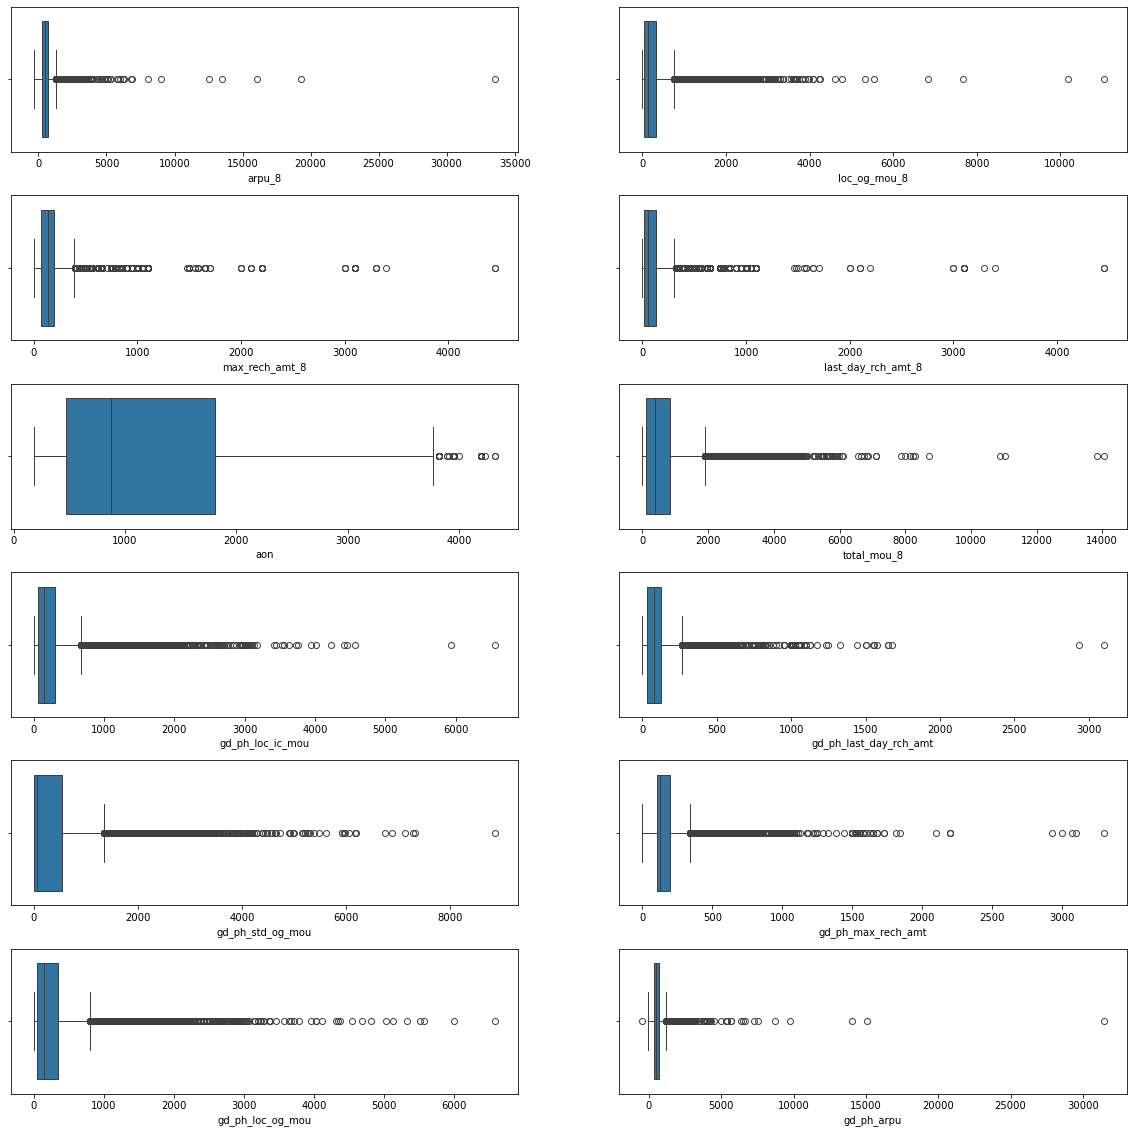

In [37]:
# Going through the output of describe we can filter out the features that needs a second look

# List of features to be analyzed
col_boxplot = ['arpu_8', 'loc_og_mou_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'aon', 'total_mou_8',
               'gd_ph_loc_ic_mou', 'gd_ph_last_day_rch_amt', 'gd_ph_std_og_mou', 'gd_ph_max_rech_amt',
              'gd_ph_loc_og_mou', 'gd_ph_arpu']

# Plot boxplots for each variable
fig, axes = plt.subplots(6, 2, figsize=(20, 20))
# sns.boxplot(x=churn_data['arpu_8'], ax=axes[0])
for index, col in enumerate(col_boxplot):
    i, j = divmod(index, 2)
    sns.boxplot(churn_working_data[col], ax = axes[i, j], orient = "h")

plt.subplots_adjust(hspace=0.3)
plt.show()

> ### Observations
- From the above plots we can define following upper limits to the suspected variables

> | Feature | Value | | --- | --- | | arpu_8 | 7000| | loc_og_mou_8 | 4000| | max_rech_amt_8 | 1000 | | last_day_rch_amt_8 | 1000 | | aon | 3000 | | total_mou_8 | 4000 | | gd_ph_loc_ic_mou | 3000 | | gd_ph_last_day_rch_amt | 1000 | | gd_ph_std_og_mou | 4000 | | gd_ph_max_rech_amt | 1500 | | gd_ph_loc_og_mou | 3000 | | gd_ph_arpu | 7000 |

> - We will make these changes post exploration of other features

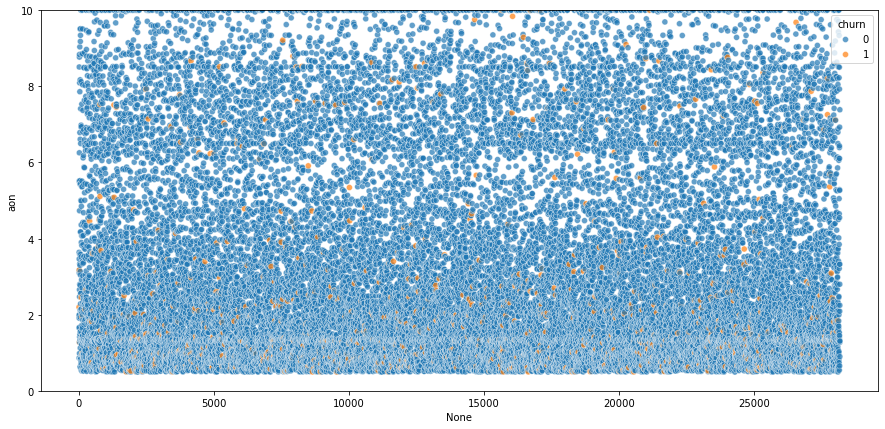

In [38]:
# Checking churn based on tenure

plt.figure(figsize=(15,7))
sns.scatterplot(y=churn_working_data['aon'] / 365, x=churn_working_data.index, hue=churn_working_data.churn, alpha=0.7)
plt.ylim(0,10)
plt.show()

> ### Observation

> - Though we cannot see a clear pattern here, but we can notice that the majority of churners had a tenure of less than 4 years

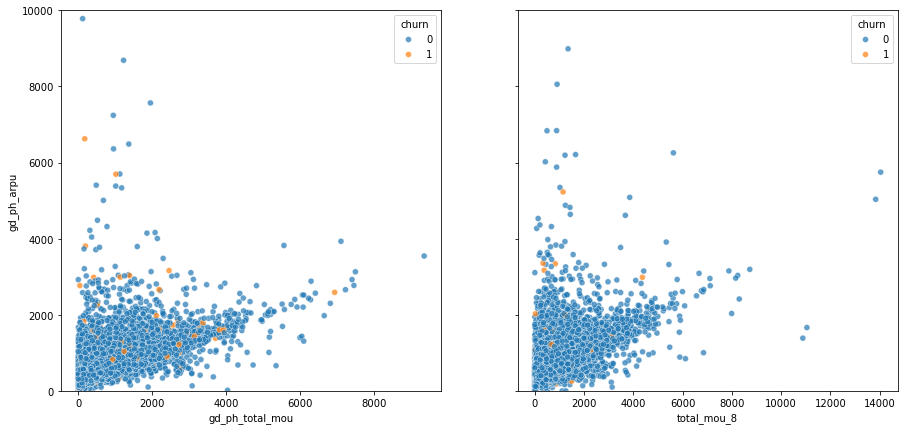

In [39]:
# Checking how the VBC effects the revenue

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
sns.scatterplot(y = 'gd_ph_arpu', x = 'gd_ph_total_mou', data = churn_working_data, ax = axes[0], hue = 'churn', alpha = 0.7)
sns.scatterplot(y = 'arpu_8', x = 'total_mou_8', data = churn_working_data, ax = axes[1], hue = 'churn', alpha = 0.7)


# Limiting the graph to more general upper bound
plt.ylim(0,10000)
plt.show()

> ### Observation
> - We can clearly see that MOU have dropped significantly for the churners in the action phase i.e 8th month, thus hitting the revenue generated from them
> - It is also interesting that though the MOU is between 0-2000, the revenue is highest in that region that tells us these users had other services that were boosting the revenue

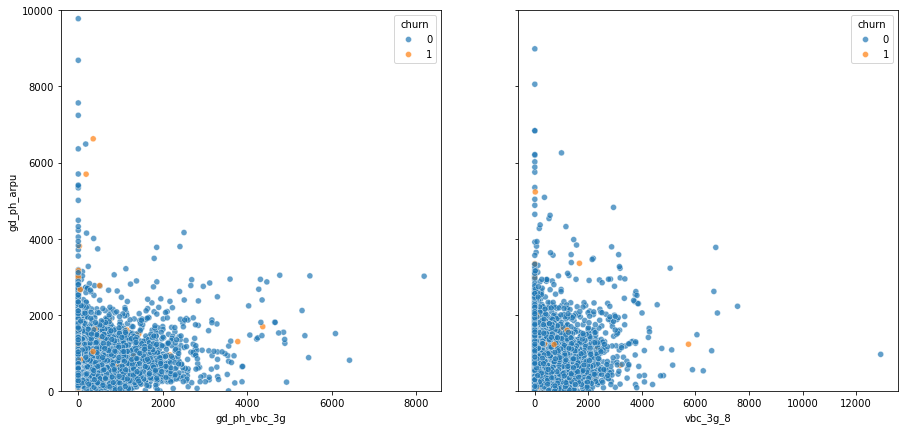

In [40]:
# Checking how the total_mou effects the revenue

fig, axes = plt.subplots(1, 2, sharey = True, figsize = (15, 7))
sns.scatterplot(y = 'gd_ph_arpu', x = 'gd_ph_vbc_3g', data = churn_working_data, ax = axes[0], hue = 'churn', alpha = 0.7)
sns.scatterplot(y = 'arpu_8', x = 'vbc_3g_8', data = churn_working_data, ax = axes[1], hue = 'churn', alpha = 0.7)


# Limiting the graph to more general upper bound
plt.ylim(0,10000)
plt.show()

> ### Observation
> - We can see that the users who were using very less amount of VBC data and yet were generating high revenue churned
> - Yet again we see that the revenue is higher towards the lesser consumption side

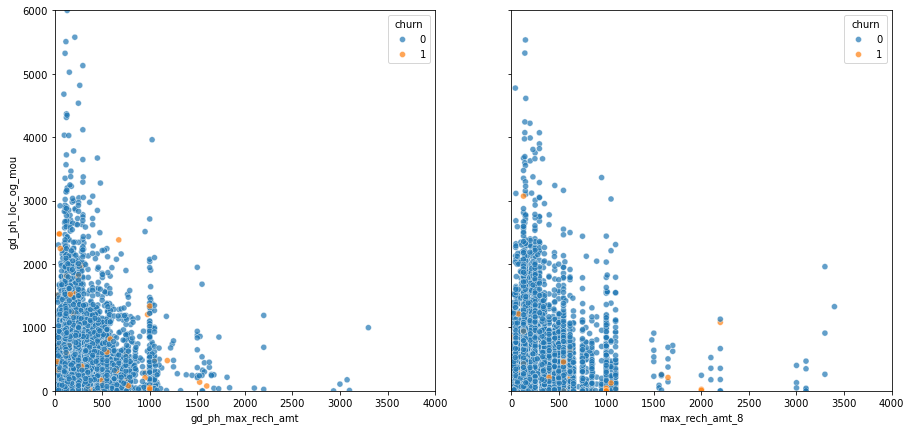

In [41]:
# Checking the relation between recharge amount and local outgoing calls

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
sns.scatterplot(x = 'gd_ph_max_rech_amt', y = 'gd_ph_loc_og_mou', data = churn_working_data, ax = axes[0],
                hue = 'churn', alpha = 0.7)
sns.scatterplot(x = 'max_rech_amt_8', y = 'loc_og_mou_8', data = churn_working_data, ax = axes[1], hue = 'churn', alpha = 0.7)

# Limiting the graph to more general upper bound
axes[0].set_xlim(0,4000)
axes[1].set_xlim(0,4000)
plt.ylim(0,6000)

plt.show()

> #### Observations
> - Users who were recharging with high amounts were using the service for local uses less as compared to user who did lesser amounts of recharge
> - Intuitively people whose max recharge amount as well as local out going were very less even in the good phase churned more

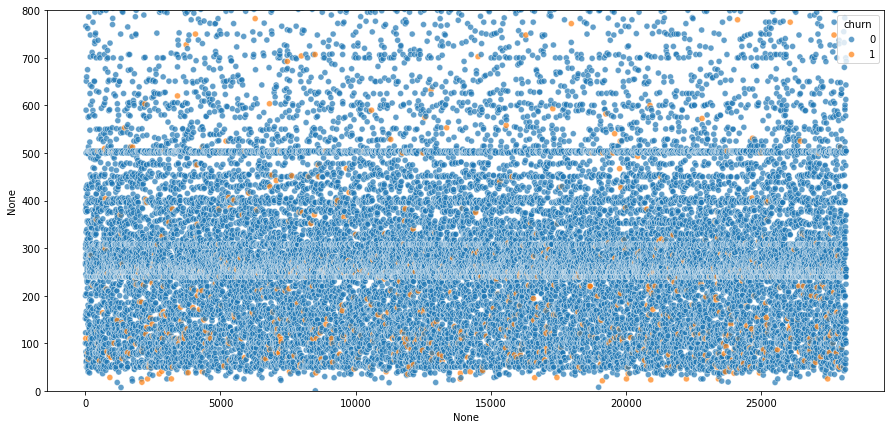

In [42]:
# Checking the effect of max recharge amount on churn

plt.figure(figsize = (15,7))
sns.scatterplot(x = churn_working_data.index, y = churn_working_data['gd_ph_max_rech_amt'] + churn_working_data['max_rech_amt_8'],
                hue=churn_working_data['churn'], alpha = 0.7)
plt.ylim(0,800)
plt.show()

> ### Observation
> - We can see that users who had the max recharge amount less than 200 churned more

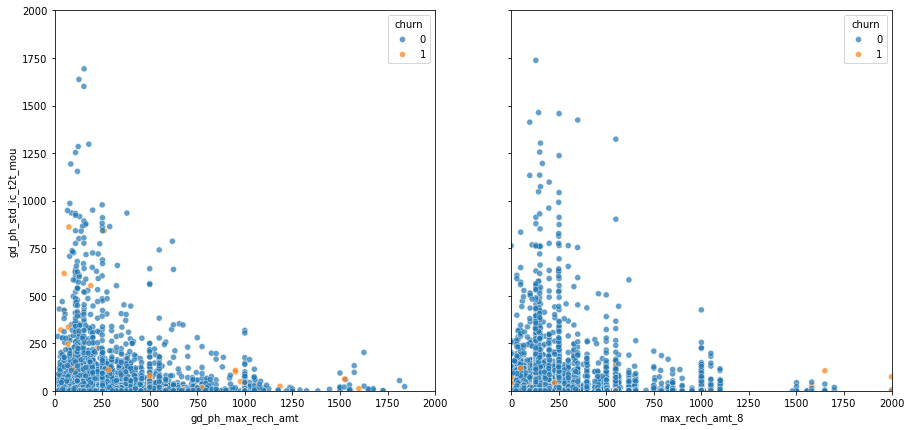

In [43]:
# Incoming from the same service provider vs the recharge amount

fig, axes = plt.subplots(1, 2, sharey = True, figsize = (15, 7))
sns.scatterplot(x = 'gd_ph_max_rech_amt', y = 'gd_ph_std_ic_t2t_mou', data = churn_working_data, ax = axes[0],
                hue ='churn', alpha = 0.7)
sns.scatterplot(x = 'max_rech_amt_8', y = 'std_ic_t2t_mou_8', data = churn_working_data, ax = axes[1], hue = 'churn', alpha = 0.7)

# Limiting the graph to more general upper bound
axes[0].set_xlim(0,2000)
axes[1].set_xlim(0,2000)
plt.ylim(0,2000)

plt.show()

> ### Observation
> - Users who have max recharge amount on the higher end and still have low incoming call mou during the good pahse, churned out more

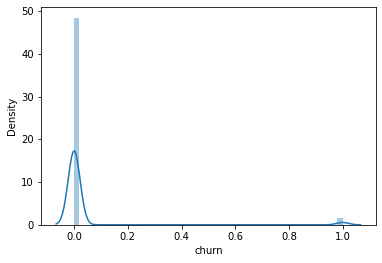

In [44]:
# Distribution of target variable

sns.distplot(churn_working_data['churn'])
plt.show()

> ### Observation
> - Though the varible is not skwed it is higly imbalanced, the number of non-churners in the dataset is around 94%
> - We will handle this imbalance using SMOTE algorithm

## 7. Data Preperation

In [45]:
# Caping the features with high outliers

col_upr_lmt = [('arpu_8', 7000), ('loc_og_mou_8', 4000), ('max_rech_amt_8', 1000 ), ('last_day_rch_amt_8', 1000 ),
               ('aon', 3000), ('total_mou_8', 4000), ('gd_ph_loc_ic_mou', 3000), ('gd_ph_last_day_rch_amt', 1000 ),
               ('gd_ph_std_og_mou', 4000), ('gd_ph_max_rech_amt', 1500), ('gd_ph_loc_og_mou', 3000), ('gd_ph_arpu', 7000)]

for col, value in col_upr_lmt:
    churn_working_data[col] = churn_working_data[col].apply(lambda x : x if x < value else value)

churn_working_data[col_boxplot].head()

,arpu_8,loc_og_mou_8,max_rech_amt_8,last_day_rch_amt_8,aon,total_mou_8,gd_ph_loc_ic_mou,gd_ph_last_day_rch_amt,gd_ph_std_og_mou,gd_ph_max_rech_amt,gd_ph_loc_og_mou,gd_ph_arpu
0,3171.480,255.79,1000,779,802,378.20,391.555,0.0,68.000,1185.0,478.035,1209.5150
1,137.362,63.04,30,10,315,171.56,52.630,25.0,136.870,122.0,333.135,435.4720
2,637.760,129.74,50,50,720,1068.53,106.505,25.0,848.990,50.0,95.565,556.1030
3,366.966,182.14,179,0,604,239.47,145.520,89.5,4.355,89.5,132.795,134.1235
4,409.230,0.00,455,455,1328,0.00,2.180,126.0,0.000,753.5,0.000,1669.9265


In [46]:
y = churn_working_data['churn']
X = churn_working_data.drop('churn', axis = 1)

#### 7.1 Standardization

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

#### 7.2 Handling Class Imbalance

In [48]:
churn_working_data.churn.value_counts()

0    27295
1      868
Name: churn, dtype: int64

In [49]:
!pip uninstall scikit-learn --yes
!pip uninstall imblearn --yes
!pip uninstall imbalanced-learn --yes
!pip install scikit-learn==1.2.2
!pip install imblearn


Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Asus\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 173, in _main
    status = self.run(options, args)
  File "C:\Users\Asus\anaconda3\lib\site-packages\pip\_internal\commands\uninstall.py", line 97, in run
    uninstall_pathset.commit()
  File "C:\Users\Asus\anaconda3\lib\site-packages\pip\_internal\req\req_uninstall.py", line 436, in commit
    self._moved_paths.commit()
  File "C:\Users\Asus\anaconda3\lib\site-packages\pip\_internal\req\req_uninstall.py", line 287, in commit
    save_dir.cleanup()
  File "C:\Users\Asus\anaconda3\lib\site-packages\pip\_internal\utils\temp_dir.py", line 184, in cleanup
    rmtree(self._path)
  File "C:\Users\Asus\anaconda3\lib\site-packages\pip\_vendor\tenacity\__init__.py", line 326, in wrapped_f
    return self(f, *args, **kw)
  File "C:\Users\Asus\anaconda3\lib\site-packages\pip\_vendor\tenacity\__init__.py", line 406, in __call__
    do = self.iter(retry_st

Found existing installation: imblearn 0.0
Uninstalling imblearn-0.0:
  Successfully uninstalled imblearn-0.0
Found existing installation: imbalanced-learn 0.12.2
Uninstalling imbalanced-learn-0.12.2:
  Successfully uninstalled imbalanced-learn-0.12.2
  Using cached scikit_learn-1.2.2-cp39-cp39-win_amd64.whl (8.4 MB)
  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.12.2-py3-none-any.whl (257 kB)


In [50]:
# Use SMOTE to take care of class imbalance

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=45, k_neighbors=5)
X_res, y_res = sm.fit_resample(X, y)

In [51]:
y_res.value_counts()

1    27295
0    27295
Name: churn, dtype: int64

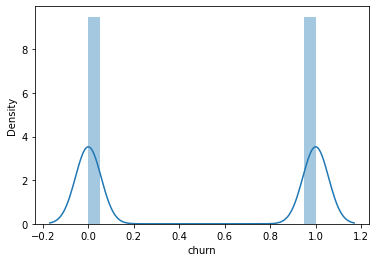

In [52]:
sns.distplot(y_res)
plt.show()

> Now the class is balanced and the target variable is not skwed

#### 7.3 PCA

In [53]:
X.shape

(28163, 55)

In [54]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 25)
X_pca = pca.fit_transform(X_res)
X_pca.shape

(54590, 25)

## 8. Model Builing

#### 8.1 Logistic Regression

> For logistic regression we will be using the unaltered X and y so that we can use RFE for feature selection instead of PCA, to find out the strong predictor of churn

In [55]:
# Spliting the data into train and test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size = 0.7, test_size = 0.3, random_state = 25)

In [56]:
import statsmodels.api as sm

In [57]:
# Initial logistic regression model

logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38213
Model:                            GLM   Df Residuals:                    38157
Model Family:                Binomial   Df Model:                           55
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17775.
Date:                Tue, 28 May 2024   Deviance:                       35550.
Time:                        09:43:39   Pearson chi2:                 1.33e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3662
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.3740      0.022    -63.039      0.000      -1.417      -1.331
arpu_8                     0.4260      0.048      8.816      0.000       0.331       0.521
roam_ic_mou_8             -0.3696      0.033    -11.128      0.000      -0.435      -0.304
roam_og_mou_8              0.0087      0.032      0.270      0.787      -0.054       0.072
loc_og_t2c_mou_8           0.0784      0.023      3.363      0.001       0.033       0.124
loc_og_mou_8              -0.2405      0.086     -2.806      0.005      -0.408      -0.073
std_og_t2f_mou_8          -0.0593      0.035     -1.709      0.087      -0.127       0.009
std_og_mou_8              -0.0548      0.119     -0.460      0.646      -0.288       0.179
isd_og_mou_8              -0.2101      0.070     -2.983      0.003      -0.348      -0.072
spl_og_mou_8              -0.1882      0.035     -5.426      0.000      -0.256      -0.120
og_others_8                0.0900      0.022      4.018      0.000       0.046       0.134
loc_ic_mou_8              -1.6791      0.058    -29.154      0.000      -1.792      -1.566
std_ic_t2t_mou_8          -0.5167      0.062     -8.287      0.000      -0.639      -0.394
std_ic_t2f_mou_8          -0.0123      0.038     -0.320      0.749      -0.088       0.063
std_ic_mou_8              -0.1742      0.046     -3.815      0.000      -0.264      -0.085
spl_ic_mou_8              -0.2695      0.023    -11.865      0.000      -0.314      -0.225
isd_ic_mou_8              -0.1751      0.029     -5.967      0.000      -0.233      -0.118
ic_others_8                0.1956      0.033      5.998      0.000       0.132       0.259
total_rech_num_8          -0.4350      0.033    -13.078      0.000      -0.500      -0.370
max_rech_amt_8             0.1979      0.024      8.263      0.000       0.151       0.245
last_day_rch_amt_8        -0.5680      0.022    -26.398      0.000      -0.610      -0.526
vol_2g_mb_8               -0.3027      0.031     -9.857      0.000      -0.363      -0.243
monthly_2g_8              -0.5765      0.027    -21.018      0.000      -0.630      -0.523
sachet_2g_8               -0.5892      0.030    -19.664      0.000      -0.648      -0.530
monthly_3g_8              -0.8860      0.037    -23.700      0.000      -0.959      -0.813
sachet_3g_8               -0.3519      0.034    -10.418      0.000      -0.418      -0.286
aon                       -0.4162      0.016    -25.290      0.000      -0.448      -0.384
total_mou_8               -0.7980      0.133     -5.996      0.000      -1.059      -0.537
gd_ph_std_ic_mou           0.0365      0.032      1.151      0.250      -0.026       0.099
gd_ph_std_og_t2f_mou      -0.0323      0.030     -1.061      0.289      -0.092       0.027
gd_ph_spl_og_mou           0.1796      0.029      6.229      0.000       0.123  

#### 8.1.1 RFE for Feature Selection

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Creating LR object

logreg = LogisticRegression(solver = 'liblinear')

# Running RFE for 25 features

rfe = RFE(logreg, n_features_to_select = 25)
rfe = rfe.fit(X_train, y_train)

In [59]:
rfe_col = X.columns[rfe.support_]
rfe_col

Index(['arpu_8', 'roam_ic_mou_8', 'loc_og_mou_8', 'loc_ic_mou_8',
       'std_ic_t2t_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'aon', 'total_mou_8', 'gd_ph_total_mou',
       'gd_ph_std_ic_t2t_mou', 'gd_ph_std_og_mou', 'gd_ph_loc_og_mou',
       'gd_ph_ic_others', 'gd_ph_monthly_3g', 'gd_ph_roam_og_mou',
       'gd_ph_loc_ic_mou', 'gd_ph_vol_2g_mb', 'gd_ph_total_rech_num'],
      dtype='object')

In [60]:
# Building model with RFE selected features

X_train_sm = sm.add_constant(X_train[rfe_col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38213
Model:                            GLM   Df Residuals:                    38187
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18047.
Date:                Tue, 28 May 2024   Deviance:                       36095.
Time:                        09:44:07   Pearson chi2:                 2.25e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3571
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.3137      0.021    -62.145      0.000      -1.355      -1.272
arpu_8                   0.3742      0.032     11.610      0.000       0.311       0.437
roam_ic_mou_8           -0.3210      0.025    -12.988      0.000      -0.369      -0.273
loc_og_mou_8            -0.1911      0.045     -4.275      0.000      -0.279      -0.103
loc_ic_mou_8            -1.7291      0.057    -30.520      0.000      -1.840      -1.618
std_ic_t2t_mou_8        -0.6287      0.056    -11.300      0.000      -0.738      -0.520
spl_ic_mou_8            -0.2793      0.022    -12.445      0.000      -0.323      -0.235
total_rech_num_8        -0.5626      0.031    -17.921      0.000      -0.624      -0.501
max_rech_amt_8           0.2374      0.022     10.828      0.000       0.194       0.280
last_day_rch_amt_8      -0.5845      0.021    -27.632      0.000      -0.626      -0.543
vol_2g_mb_8             -0.3008      0.030     -9.867      0.000      -0.361      -0.241
monthly_2g_8            -0.6617      0.024    -27.335      0.000      -0.709      -0.614
sachet_2g_8             -0.4993      0.023    -21.962      0.000      -0.544      -0.455
monthly_3g_8            -0.9129      0.035    -26.001      0.000      -0.982      -0.844
aon                     -0.4204      0.016    -26.255      0.000      -0.452      -0.389
total_mou_8             -0.7930      0.036    -21.908      0.000      -0.864      -0.722
gd_ph_total_mou         -0.8399      0.196     -4.291      0.000      -1.223      -0.456
gd_ph_std_ic_t2t_mou     0.2059      0.026      7.787      0.000       0.154       0.258
gd_ph_std_og_mou         0.9871      0.172      5.724      0.000       0.649       1.325
gd_ph_loc_og_mou         0.6947      0.109      6.381      0.000       0.481       0.908
gd_ph_ic_others         -0.2679      0.052     -5.142      0.000      -0.370      -0.166
gd_ph_monthly_3g         0.2369      0.023     10.471      0.000       0.193       0.281
gd_ph_roam_og_mou        0.2940      0.032      9.199      0.000       0.231       0.357
gd_ph_loc_ic_mou         0.8439      0.040     21.341      0.000       0.766       0.921
gd_ph_vol_2g_mb          0.2149      0.020     10.579      0.000       0.175       0.255
gd_ph_total_rech_num     0.3520      0.023     15.201      0.000       0.307       0.397
========================================================================================
"""

In [61]:
# Predicting on train data

y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()


,Churn,Churn_Prob,predicted
0,1,0.553536,1
1,1,0.617986,1
2,1,0.856813,1
3,0,0.149264,0
4,0,0.862301,1


In [62]:
from sklearn import metrics

# Confusion matrix

confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

print()

# The overall accuracy

print(f'Accuracy : {metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')

[[14636  4444]
 [ 3421 15712]]

Accuracy : 0.7941799911025044


In [63]:
# Check for the VIF values of the feature variables

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
15,gd_ph_total_mou,89.44
17,gd_ph_std_og_mou,80.52
18,gd_ph_loc_og_mou,24.10
14,total_mou_8,4.34
2,loc_og_mou_8,4.33
0,arpu_8,4.20
3,loc_ic_mou_8,3.76
22,gd_ph_loc_ic_mou,3.42
6,total_rech_num_8,3.12
21,gd_ph_roam_og_mou,2.99


> Since the VIF for total_mou_8 is very high we will drop it

In [64]:
rfe_col = rfe_col.drop('total_mou_8', 1)

In [65]:
# Building new model

X_train_sm = sm.add_constant(X_train[rfe_col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38213
Model:                            GLM   Df Residuals:                    38188
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18316.
Date:                Tue, 28 May 2024   Deviance:                       36633.
Time:                        09:44:08   Pearson chi2:                 2.10e+07
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3480
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.3049      0.021    -61.516      0.000      -1.347      -1.263
arpu_8                   0.0522      0.027      1.928      0.054      -0.001       0.105
roam_ic_mou_8           -0.2970      0.024    -12.517      0.000      -0.344      -0.251
loc_og_mou_8            -0.4508      0.043    -10.556      0.000      -0.534      -0.367
loc_ic_mou_8            -1.7926      0.057    -31.309      0.000      -1.905      -1.680
std_ic_t2t_mou_8        -0.7264      0.057    -12.699      0.000      -0.838      -0.614
spl_ic_mou_8            -0.2828      0.022    -12.637      0.000      -0.327      -0.239
total_rech_num_8        -0.7940      0.031    -26.015      0.000      -0.854      -0.734
max_rech_amt_8           0.2939      0.022     13.667      0.000       0.252       0.336
last_day_rch_amt_8      -0.5941      0.021    -28.178      0.000      -0.635      -0.553
vol_2g_mb_8             -0.2855      0.030     -9.389      0.000      -0.345      -0.226
monthly_2g_8            -0.6380      0.024    -26.198      0.000      -0.686      -0.590
sachet_2g_8             -0.4610      0.023    -20.147      0.000      -0.506      -0.416
monthly_3g_8            -0.8403      0.035    -24.040      0.000      -0.909      -0.772
aon                     -0.4060      0.016    -25.463      0.000      -0.437      -0.375
gd_ph_total_mou         -0.3961      0.174     -2.276      0.023      -0.737      -0.055
gd_ph_std_ic_t2t_mou     0.2378      0.027      8.672      0.000       0.184       0.292
gd_ph_std_og_mou         0.2842      0.152      1.875      0.061      -0.013       0.581
gd_ph_loc_og_mou         0.4332      0.098      4.434      0.000       0.242       0.625
gd_ph_ic_others         -0.2414      0.052     -4.633      0.000      -0.343      -0.139
gd_ph_monthly_3g         0.2435      0.023     10.787      0.000       0.199       0.288
gd_ph_roam_og_mou        0.1957      0.029      6.839      0.000       0.140       0.252
gd_ph_loc_ic_mou         0.9160      0.040     22.848      0.000       0.837       0.995
gd_ph_vol_2g_mb          0.2000      0.020      9.857      0.000       0.160       0.240
gd_ph_total_rech_num     0.5174      0.022     23.110      0.000       0.474       0.561
========================================================================================
"""

In [66]:
# Predicting on train data

y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,1,0.481791,0
1,1,0.590866,1
2,1,0.888077,1
3,0,0.175523,0
4,0,0.849561,1


In [67]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

print()

# The overall accuracy
print(f'Accuracy : {metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')

[[14407  4673]
 [ 3312 15821]]

Accuracy : 0.7910396985319132


In [68]:
# Checking for the VIF values of the feature variables

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
14,gd_ph_total_mou,89.42
16,gd_ph_std_og_mou,79.37
17,gd_ph_loc_og_mou,24.08
2,loc_og_mou_8,3.85
3,loc_ic_mou_8,3.76
0,arpu_8,3.41
21,gd_ph_loc_ic_mou,3.41
20,gd_ph_roam_og_mou,2.98
6,total_rech_num_8,2.76
7,max_rech_amt_8,2.56


In [69]:
# Droping 'gd_ph_total_mou'
rfe_col = rfe_col.drop('gd_ph_total_mou', 1)

In [70]:
# Building new model

X_train_sm = sm.add_constant(X_train[rfe_col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38213
Model:                            GLM   Df Residuals:                    38189
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18319.
Date:                Tue, 28 May 2024   Deviance:                       36638.
Time:                        09:44:10   Pearson chi2:                 2.35e+07
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3479
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.3031      0.021    -61.510      0.000      -1.345      -1.262
arpu_8                   0.0375      0.026      1.422      0.155      -0.014       0.089
roam_ic_mou_8           -0.2957      0.024    -12.457      0.000      -0.342      -0.249
loc_og_mou_8            -0.4470      0.043    -10.504      0.000      -0.530      -0.364
loc_ic_mou_8            -1.7892      0.057    -31.288      0.000      -1.901      -1.677
std_ic_t2t_mou_8        -0.7244      0.057    -12.677      0.000      -0.836      -0.612
spl_ic_mou_8            -0.2833      0.022    -12.660      0.000      -0.327      -0.239
total_rech_num_8        -0.7851      0.030    -25.984      0.000      -0.844      -0.726
max_rech_amt_8           0.2943      0.021     13.691      0.000       0.252       0.336
last_day_rch_amt_8      -0.5923      0.021    -28.122      0.000      -0.634      -0.551
vol_2g_mb_8             -0.2848      0.030     -9.372      0.000      -0.344      -0.225
monthly_2g_8            -0.6376      0.024    -26.182      0.000      -0.685      -0.590
sachet_2g_8             -0.4627      0.023    -20.229      0.000      -0.508      -0.418
monthly_3g_8            -0.8372      0.035    -23.976      0.000      -0.906      -0.769
aon                     -0.4055      0.016    -25.434      0.000      -0.437      -0.374
gd_ph_std_ic_t2t_mou     0.2373      0.027      8.661      0.000       0.184       0.291
gd_ph_std_og_mou        -0.0594      0.015     -4.020      0.000      -0.088      -0.030
gd_ph_loc_og_mou         0.2229      0.032      7.057      0.000       0.161       0.285
gd_ph_ic_others         -0.2410      0.052     -4.625      0.000      -0.343      -0.139
gd_ph_monthly_3g         0.2426      0.023     10.752      0.000       0.198       0.287
gd_ph_roam_og_mou        0.1406      0.015      9.261      0.000       0.111       0.170
gd_ph_loc_ic_mou         0.9142      0.040     22.803      0.000       0.836       0.993
gd_ph_vol_2g_mb          0.1987      0.020      9.801      0.000       0.159       0.238
gd_ph_total_rech_num     0.5118      0.022     23.037      0.000       0.468       0.555
========================================================================================
"""

In [71]:
# Predicting on train data

y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,1,0.481887,0
1,1,0.586067,1
2,1,0.887662,1
3,0,0.174415,0
4,0,0.849397,1


In [72]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

print()

# The overall accuracy.
print(f'Accuracy : {metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')

[[14416  4664]
 [ 3318 15815]]

Accuracy : 0.791118205846178


In [73]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,loc_og_mou_8,3.84
3,loc_ic_mou_8,3.75
20,gd_ph_loc_ic_mou,3.41
16,gd_ph_loc_og_mou,3.34
0,arpu_8,3.30
6,total_rech_num_8,2.74
7,max_rech_amt_8,2.56
22,gd_ph_total_rech_num,2.12
8,last_day_rch_amt_8,1.94
12,monthly_3g_8,1.88


In [74]:
# Droping 'loc_ic_mou_8'
rfe_col = rfe_col.drop('loc_ic_mou_8', 1)

In [75]:
# Building new model
X_train_sm = sm.add_constant(X_train[rfe_col])
logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38213
Model:                            GLM   Df Residuals:                    38190
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18956.
Date:                Tue, 28 May 2024   Deviance:                       37913.
Time:                        09:44:11   Pearson chi2:                 7.48e+07
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3257
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.1499      0.020    -58.638      0.000      -1.188      -1.111
arpu_8                  -0.0084      0.027     -0.316      0.752      -0.061       0.044
roam_ic_mou_8           -0.2320      0.023     -9.988      0.000      -0.278      -0.186
loc_og_mou_8            -1.1382      0.044    -26.056      0.000      -1.224      -1.053
std_ic_t2t_mou_8        -0.8470      0.058    -14.567      0.000      -0.961      -0.733
spl_ic_mou_8            -0.3019      0.023    -13.381      0.000      -0.346      -0.258
total_rech_num_8        -0.9127      0.030    -30.101      0.000      -0.972      -0.853
max_rech_amt_8           0.2887      0.021     13.572      0.000       0.247       0.330
last_day_rch_amt_8      -0.5932      0.021    -28.222      0.000      -0.634      -0.552
vol_2g_mb_8             -0.3138      0.031    -10.279      0.000      -0.374      -0.254
monthly_2g_8            -0.6491      0.024    -27.087      0.000      -0.696      -0.602
sachet_2g_8             -0.4688      0.023    -20.569      0.000      -0.513      -0.424
monthly_3g_8            -0.8382      0.034    -24.444      0.000      -0.905      -0.771
aon                     -0.4170      0.016    -26.887      0.000      -0.447      -0.387
gd_ph_std_ic_t2t_mou     0.2808      0.027     10.485      0.000       0.228       0.333
gd_ph_std_og_mou        -0.0235      0.015     -1.612      0.107      -0.052       0.005
gd_ph_loc_og_mou         0.5793      0.032     18.384      0.000       0.518       0.641
gd_ph_ic_others         -0.1913      0.046     -4.120      0.000      -0.282      -0.100
gd_ph_monthly_3g         0.2357      0.022     10.722      0.000       0.193       0.279
gd_ph_roam_og_mou        0.1274      0.015      8.267      0.000       0.097       0.158
gd_ph_loc_ic_mou        -0.1326      0.019     -6.969      0.000      -0.170      -0.095
gd_ph_vol_2g_mb          0.2035      0.020     10.213      0.000       0.164       0.243
gd_ph_total_rech_num     0.5870      0.022     26.586      0.000       0.544       0.630
========================================================================================
"""

In [76]:
# Predicting on train data

y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()


,Churn,Churn_Prob,predicted
0,1,0.476405,0
1,1,0.675759,1
2,1,0.897211,1
3,0,0.231516,0
4,0,0.839915,1


In [77]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

print()

# The overall accuracy
print(f'Accuracy : {metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')

[[14216  4864]
 [ 3566 15567]]

Accuracy : 0.779394446915971


In [78]:
# Creating a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,loc_og_mou_8,3.30
0,arpu_8,3.29
15,gd_ph_loc_og_mou,3.09
5,total_rech_num_8,2.70
6,max_rech_amt_8,2.56
21,gd_ph_total_rech_num,2.09
7,last_day_rch_amt_8,1.94
11,monthly_3g_8,1.88
8,vol_2g_mb_8,1.85
17,gd_ph_monthly_3g,1.81


> The VIF values looks good now, we can proceed further

In [79]:
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [80]:
# Checking the sensitivity of our logistic regression model

TP / float(TP+FN)

0.8136204463492396

In [81]:
# Calculating the Specificity

TN / float(TN+FP)

0.7450733752620545

In [82]:
# Calculating false postive rate - predicting churn when customer does not have churned

print(FP/ float(TN+FP))

0.2549266247379455


In [83]:
# positive predictive value

print (TP / float(TP+FP))

0.7619303998825314


In [84]:
# Negative predictive value

print (TN / float(TN+ FN))

0.7994601282195478


#### 8.1.2 Plotting ROC

In [85]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

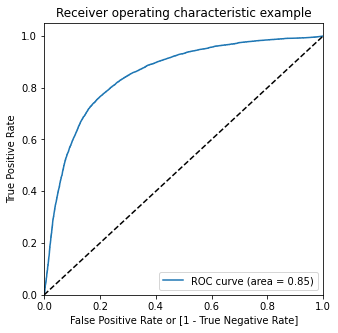

In [86]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

#### 8.1.3 Optimal cutoff point

In [87]:
# Creating columns with different probability cutoffs

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.476405,0,1,1,1,1,1,0,0,0,0,0
1,1,0.675759,1,1,1,1,1,1,1,1,0,0,0
2,1,0.897211,1,1,1,1,1,1,1,1,1,1,0
3,0,0.231516,0,1,1,1,0,0,0,0,0,0,0
4,0,0.839915,1,1,1,1,1,1,1,1,1,1,0


In [88]:
# Calculating accuracy sensitivity and specificity for various probability cutoffs.

cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5, 0.5, 0.6,0.7,0.8,0.9]

for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1 = sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1

    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] = [ i ,accuracy,sensi,speci]

print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500693  1.000000  0.000000
0.1   0.1  0.611232  0.981237  0.240199
0.2   0.2  0.680240  0.956097  0.403616
0.3   0.3  0.729124  0.921392  0.536321
0.4   0.4  0.761469  0.875294  0.647327
0.5   0.5  0.779394  0.813620  0.745073
0.6   0.6  0.780415  0.725553  0.835430
0.7   0.7  0.742130  0.581038  0.903669
0.8   0.8  0.656452  0.356034  0.957704
0.9   0.9  0.536388  0.083939  0.990094


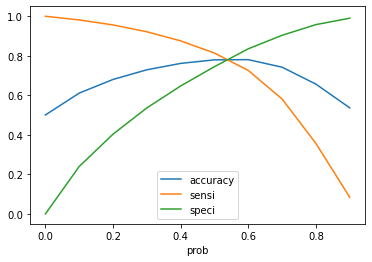

In [89]:
# Plotting accuracy sensitivity and specificity for various probabilities.

cutoff_df.plot.line(x = 'prob', y = ['accuracy','sensi','speci'])
plt.show()

> The point 0.5 is optimal for our model, so we will keep that

In [90]:
X_test = X_test[rfe_col]
X_test_sm = sm.add_constant(X_test)

# Predicting on test data

y_test_pred = res.predict(X_test_sm)
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':y_test_pred})
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_final.head()

,Churn,Churn_Prob,predicted
38017,1,0.210996,0
7994,0,0.258003,0
51540,1,0.633928,1
26903,0,0.564385,1
15570,0,0.430887,0


In [91]:
# Confusion matrix

confusion = metrics.confusion_matrix(y_test_pred_final.Churn, y_test_pred_final.predicted )
print(confusion)

print()

# The overall accuracy

print(f'Accuracy : {metrics.accuracy_score(y_test_pred_final.Churn, y_test_pred_final.predicted)}')

[[6149 2066]
 [1467 6695]]

Accuracy : 0.7842706234353056


In [92]:
# Top 10 predictors

abs(res.params).sort_values(ascending = False)[0:11]

const                   1.149932
loc_og_mou_8            1.138188
total_rech_num_8        0.912711
std_ic_t2t_mou_8        0.846979
monthly_3g_8            0.838237
monthly_2g_8            0.649077
last_day_rch_amt_8      0.593235
gd_ph_total_rech_num    0.586985
gd_ph_loc_og_mou        0.579306
sachet_2g_8             0.468771
aon                     0.417008
dtype: float64

> - So using Logistic regression we are geting an accuracy of 78.5% on train data and 78.8% on test data
> - We can clearly see most of the critical features are form the action phase, which is inline with the bussiness understanding that action phase needs more attention

#### 8.2 Decision Tree

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_res, train_size = 0.7, random_state = 25)

In [94]:
from sklearn.tree import DecisionTreeClassifier

# Initial classifier
intial_dt = DecisionTreeClassifier(random_state=42, max_depth=10)
intial_dt.fit(X_train, y_train)

# Train Accuracy
y_train_pred = intial_dt.predict(X_train)
print(f'Train accuracy : {metrics.accuracy_score(y_train, y_train_pred)}')

y_test_pred = intial_dt.predict(X_test)

# Print the report on test data
print(metrics.classification_report(y_test, y_test_pred))

Train accuracy : 0.8804071912699867
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      8215
           1       0.82      0.90      0.86      8162

    accuracy                           0.85     16377
   macro avg       0.85      0.85      0.85     16377
weighted avg       0.85      0.85      0.85     16377



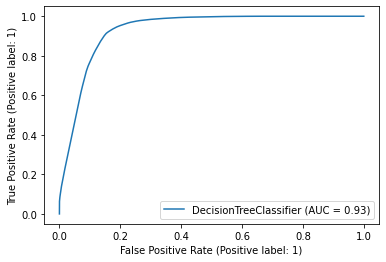

In [95]:
# Plotting ROC curve
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(intial_dt, X_train, y_train)
plt.show()

#### 8.2.1 Hyperparameter Tuning

In [96]:
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state = 42)

# Define parameters
params = {
    "max_depth": [2, 3, 5, 10, 20, 30, 40, 50, 100],
    "min_samples_leaf": [5, 10, 20, 50, 100, 250, 500, 800, 1000],
    "min_samples_leaf" : [1, 5, 10, 25, 50, 100]
}

grid_search = GridSearchCV(estimator = dt,
                           param_grid = params,
                           cv = 4,
                           n_jobs = -1, verbose = 1, scoring = "accuracy")

# Perform gridsearch
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 54 candidates, totalling 216 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20, 30, 40, 50, 100],
                         'min_samples_leaf': [1, 5, 10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [97]:
grid_search.best_score_

0.882997938563436

In [98]:
# Best estimator
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=40, random_state=42)

In [99]:
y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)

# Print the report
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      8215
           1       0.87      0.93      0.90      8162

    accuracy                           0.89     16377
   macro avg       0.90      0.89      0.89     16377
weighted avg       0.90      0.89      0.89     16377



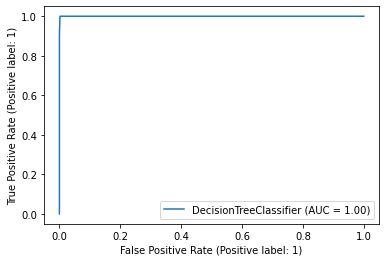

In [100]:
# ROC
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(dt_best, X_train, y_train)
plt.show()

> We are getting an accuracy of 90% on test data, with decission tree

#### 8.3 Random Forest

Train accuracy : 0.8804071912699867
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      8215
           1       0.87      0.93      0.90      8162

    accuracy                           0.89     16377
   macro avg       0.90      0.89      0.89     16377
weighted avg       0.90      0.89      0.89     16377



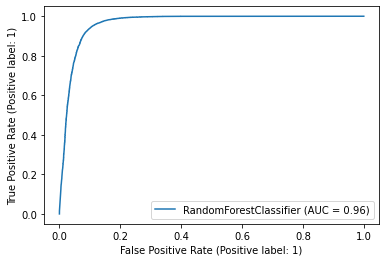

In [101]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=15, max_depth=10, max_features=5, random_state=25, oob_score=True)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)

# Train Accuracy
y_train_pred = intial_dt.predict(X_train)
print(f'Train accuracy : {metrics.accuracy_score(y_train, y_train_pred)}')

y_test_pred = rf.predict(X_test)

# Print the report
print(metrics.classification_report(y_test, y_test_pred))

# Plotting ROC
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rf, X_train, y_train)
plt.show()

#### 8.3.1 Hyperparameter Tuning

In [102]:
rf = RandomForestClassifier(random_state=25, n_jobs=-1)

# Define parameters
params = {
    'max_depth': [2, 3, 5, 10, 20, 30],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'n_estimators': [10, 25, 50, 100]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=25),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20, 30],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [103]:
grid_search.best_score_

0.9429251515968743

In [104]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=30, min_samples_leaf=5, n_jobs=-1,
                       random_state=25)

In [105]:
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

# Print the report
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      8215
           1       0.94      0.97      0.95      8162

    accuracy                           0.95     16377
   macro avg       0.95      0.95      0.95     16377
weighted avg       0.95      0.95      0.95     16377



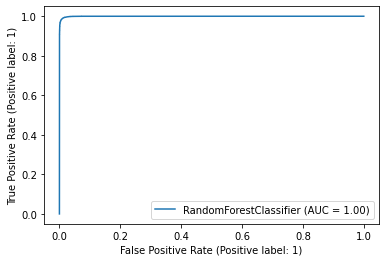

In [106]:
RocCurveDisplay.from_estimator(rf_best, X_train, y_train)
plt.show()

> We are getting an accuracy of 95% on test data, with Random forest

## 9. Conclusions

- Given our business problem, to retain their customers, we need higher recall. As giving an offer to an user not going to churn will cost less as compared to loosing a customer and bring new customer, we need to have high rate of correctly identifying the true positives, hence recall.

- When we compare the models trained we can see the tuned random forest is performing the best, which is highest accuracy along with highest recall i.e. 95%. So, we will go with random forest.

In [107]:
final_model = RandomForestClassifier(max_depth = 30, min_samples_leaf = 5, n_jobs = -1, random_state = 25)

In [108]:
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)



# Print the report
print("Report on train data")
print(metrics.classification_report(y_train, y_train_pred))

print("Report on test data")
print(metrics.classification_report(y_test, y_test_pred))

Report on train data
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     19080
           1       0.98      0.99      0.99     19133

    accuracy                           0.99     38213
   macro avg       0.99      0.99      0.99     38213
weighted avg       0.99      0.99      0.99     38213

Report on test data
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      8215
           1       0.94      0.97      0.95      8162

    accuracy                           0.95     16377
   macro avg       0.95      0.95      0.95     16377
weighted avg       0.95      0.95      0.95     16377



## 10. Strategies to Manage Customer Churn

The top 10 predictors are :

  **Features**

**------------------**
  1. loc_og_mou_8

  2. total_rech_num_8

  3. monthly_3g_8

  4. monthly_2g_8

  5. gd_ph_loc_og_mou

  6. gd_ph_total_rech_num

  7. last_day_rch_amt_8

  8. std_ic_t2t_mou_8

  9. sachet_2g_8

  10. aon

- We can see most of the top predictors are from the action phase, as the drop in engagement is prominent in that phase

Some of the factors we noticed while performing EDa which can be clubed with these inshigts are:

1. Users whose maximum recharge amount is less than 200 even in the good phase, should have a tag and re-evaluated time to time as they are more likely to churn
2. Users that have been with the network less than 4 years, should be monitored time to time, as from data we can see that users who have been associated with the network for less than 4 years tend to churn more
3. MOU is one of the major factors, but data especially VBC if the user is not using a data pack if another factor to look out